<a href="https://colab.research.google.com/github/Srichandan10/git-remote-add-origin-https-github.com-Srichandan10-Generate-Synthetic-Images-with-DCGANs-in-Keras/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display



In [3]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
x_train=x_train.astype(np.float32)/255
x_test=x_test.astype(np.float32)/255


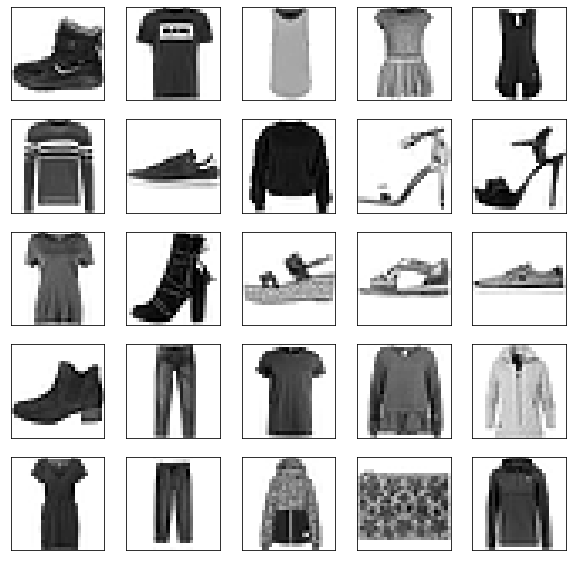

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i],cmap=plt.cm.binary)


In [6]:
batch_size=32
dataset=tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset=dataset.batch(batch_size,drop_remainder=True).prefetch(1)

In [7]:
num_features=100

generator=keras.models.Sequential([
                                   keras.layers.Dense(7*7*256,input_shape=[num_features]),
                                   keras.layers.Reshape([7,7,256]),
                                   keras.layers.BatchNormalization(),
                                   keras.layers.Conv2DTranspose(64,(5,5),(2,2),padding='same',activation='selu'),
                                   keras.layers.BatchNormalization(),
                                   keras.layers.Conv2DTranspose(1,(5,5),(2,2),padding='same',activation='tanh'),

])

In [8]:
noise=tf.random.normal(shape=[1,num_features])
generated_image=generator(noise,training=False)


Building the Discriminator Network for DCGAN

In [9]:
discriminator=keras.models.Sequential([
                                       keras.layers.Conv2D(64,(5,5),(2,2),padding='same',input_shape=[28,28,1]),
                                       keras.layers.LeakyReLU(0.2),
                                       keras.layers.Dropout(0.3),
                                       keras.layers.Conv2D(128,(5,5),(2,2),padding='same'),
                                       keras.layers.LeakyReLU(0.2),
                                       keras.layers.Dropout(0.3),
                                       keras.layers.Flatten(),
                                       keras.layers.Dense(1,activation='sigmoid')
])


In [10]:

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [11]:
decision=discriminator(generated_image)
print(decision)

tf.Tensor([[0.49970526]], shape=(1, 1), dtype=float32)


In [12]:
discriminator.compile(loss='binary_crossentropy',optimizer='rmsprop')
discriminator.trainable=False
gan=keras.models.Sequential([generator,discriminator])
gan.compile(loss='binary_crossentropy',optimizer='rmsprop')

In [13]:
seed=tf.random.normal(shape=[batch_size,100])

In [14]:
def train_dcgan(gan,dataset,batch_size,num_features, epochs=5):
  generator,discriminator=gan.layers 
  for epoch in tqdm(range(epochs)):
    print("Epochs {}/{}".format(epochs+1,epochs))
    for X_batch in dataset:
      noise=tf.random.normal(shape=[batch_size,num_features])
      generated_images=generator(noise)
      X_fake_and_real=tf.concat([generated_images,X_batch],axis=0)
      y1=tf.constant([[0.]]*batch_size+[[1.]]*batch_size)
      discriminator.trainable=True
      discriminator.train_on_batch(X_fake_and_real,y1)
      y2=tf.constant([[1.]]*batch_size)
      discriminator.trainalbe=False
      gan.train_on_batch(noise,y2)
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch+1,seed)
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

In [15]:
x_train_dcgan=x_train.reshape(-1,28,28,1)*2.-1.


In [16]:
def generate_and_save_images(model,epoch, test_input):
  predictions=model(test_input,training=False)
  fig=plt.figure(figsize=(10,10))

  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='binary')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}'.format(epoch))
  plt.show()

In [17]:
batch_size=32
dataset=tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset=dataset.batch(batch_size,drop_remainder=True).prefetch(1)

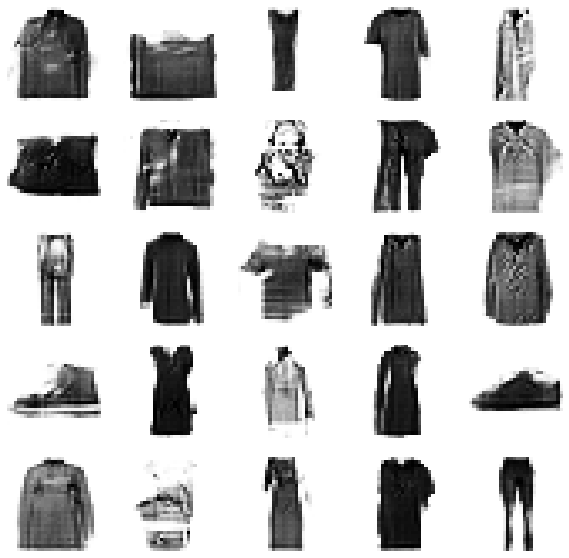

CPU times: user 27min 37s, sys: 1min 18s, total: 28min 55s
Wall time: 28min 19s


In [50]:
%%time
train_dcgan(gan,dataset,batch_size,num_features,epochs=50)